In [3]:
!pip install lightfm
!pip install pandas
!pip install kaggle
!kaggle datasets download -d rdoume/beerreviews
!unzip beerreviews.zip
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=806104 sha256=73701e16c714ede12275dfb335191c87543a7a8a586a381b05f2028c92f4a29c
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm
Dataset URL: https://www.kaggle.com/datasets/rdoume/beerreviews
License(s): unknown
 95% 26.0M/27.4M [00:02<00:00, 20.7MB/s]
100% 27.4M/27.4M [00:02<00:00, 11.8MB/s]
Archive:  beerreviews.zip
  inflating: beer_reviews.csv        
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, average_precision_score, precision_score
from collections import Counter
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from google.colab import files
import joblib
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('beer_reviews.csv')

In [6]:
data = data[["review_profilename", "beer_beerid", "beer_name", "review_overall"]]

In [7]:
data['id'] = range(1, len(data) + 1)

In [8]:
unique_users = data['review_profilename'].unique()
num_users = len(unique_users)
user_features = pd.DataFrame({
    'review_profilename': unique_users,
    'age': np.random.randint(18, 65, size=num_users),
    'gender': np.random.choice(['М', 'Ж'], size=num_users),
    'location': np.random.choice(['Москва', 'Питер', 'Казань', 'Белгород'], size=num_users),
})

In [9]:
data = pd.merge(data, user_features, on='review_profilename')

In [10]:
le_beer = LabelEncoder()
data['beer_beerid_encoded'] = le_beer.fit_transform(data['beer_beerid'])

In [11]:
X = data[['age', 'gender', 'location']]
X = pd.get_dummies(X, columns=['gender', 'location'])
y = data['beer_beerid_encoded']

In [12]:
subset_size = 1000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_small, y_train_small = shuffle(X_train, y_train, random_state=42)
X_train_subset = X_train_small[:subset_size]
y_train_subset = y_train_small[:subset_size]

In [13]:
scaler = StandardScaler()
X_train_subset = scaler.fit_transform(X_train_subset)

In [14]:
min_samples = 3
class_counts = Counter(y_train_subset)
valid_classes = {cls for cls, count in class_counts.items() if count >= min_samples}

X_train_filtered = []
y_train_filtered = []

for x, y in zip(X_train_subset, y_train_subset):
    if y in valid_classes:
        X_train_filtered.append(x)
        y_train_filtered.append(y)

X_train_filtered = np.array(X_train_filtered)
y_train_filtered = np.array(y_train_filtered)

print("Распределение классов после фильтрации:", Counter(y_train_filtered))

Распределение классов после фильтрации: Counter({45728: 4, 1512: 4, 2877: 4, 7438: 3, 8862: 3, 956: 3, 509: 3, 874: 3, 2278: 3, 384: 3, 2140: 3, 1485: 3, 602: 3, 47620: 3, 92: 3, 3439: 3, 20804: 3, 3414: 3, 5072: 3, 13856: 3, 666: 3})


In [31]:
accuracies = []
losses = []
for i in range(1, 51):
    model = CatBoostClassifier(n_estimators=i, max_depth=3, random_state=42, loss_function='MultiClass', verbose=0)
    model.fit(X_train_filtered, y_train_filtered)
    y_pred = model.predict(X_train_filtered)
    y_pred_proba = model.predict_proba(X_train_filtered)
    accuracy = accuracy_score(y_train_filtered, y_pred)
    accuracies.append(accuracy)
    loss = log_loss(y_train_filtered, y_pred_proba)
    losses.append(loss)

In [ ]:
print("Введите ваши данные:")
try:
    user_age = int(input("Ваш возраст: "))
    user_gender = input("Ваш пол (м/ж): ").strip().lower()
    user_location = input("Ваш город: ").strip()

    if user_gender == 'м':
        user_gender = 'Male'
    elif user_gender == 'ж':
        user_gender = 'Female'
    else:
        print("Ошибка: Некорректный ввод пола. Используйте 'м' или 'ж'.")
        exit()

    if user_location not in ['Москва', 'Питер', 'Казань', 'Белгород']:
        print("Ошибка: Город должен быть одним из ['Москва', 'Питер', 'Казань', 'Белгород'].")
        exit()

    user_data = pd.DataFrame([{
        'age': user_age,
        'gender': user_gender,
        'location': user_location,
    }])
    user_data = pd.get_dummies(user_data, columns=['gender', 'location'])
    user_data = user_data.reindex(columns=X.columns, fill_value=0)

    predictions_proba = model.predict_proba(user_data)[0]

    top_5_indices = predictions_proba.argsort()[-5:][::-1]
    top_5_beers = le_beer.inverse_transform(top_5_indices)

    beer_names_dict = {id_: f"Пиво {id_}" for id_ in top_5_beers}

    print("Мы рекомендуем вам попробовать следующие 5 сортов пива:")
    for beer_id in top_5_beers:
        beer_name = data.loc[beer_id, 'beer_name'] if beer_id in data.index else "Неизвестное пиво"
        print(f"- {beer_name} (ID: {beer_id})")
except ValueError:
    print("Ошибка: Пожалуйста, введите числовое значение для возраста.")

Введите ваши данные:
Ваш возраст: 19
Ваш пол (м/ж): ж
Ваш город: USA
Мы рекомендуем вам попробовать следующие 5 сортов пива:
- Rauch Ür Bock (ID: 24)
- Rauch Ür Bock (ID: 23)
- Caldera OBF 15 (ID: 17)
- Caldera Ginger Beer (ID: 13)
- Cauldron DIPA (ID: 4)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
joblib.dump(model, 'model.joblib')
files.download('model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

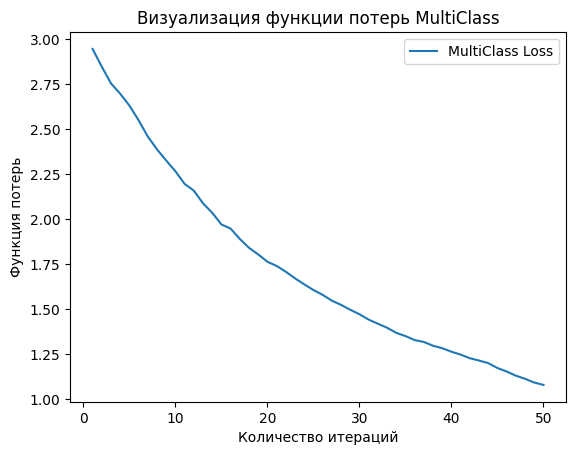

In [19]:
plt.plot(range(1, 51), losses, label='MultiClass Loss')
plt.xlabel('Количество итераций')
plt.ylabel('Функция потерь')
plt.title('Визуализация функции потерь MultiClass')
plt.legend()
plt.show()

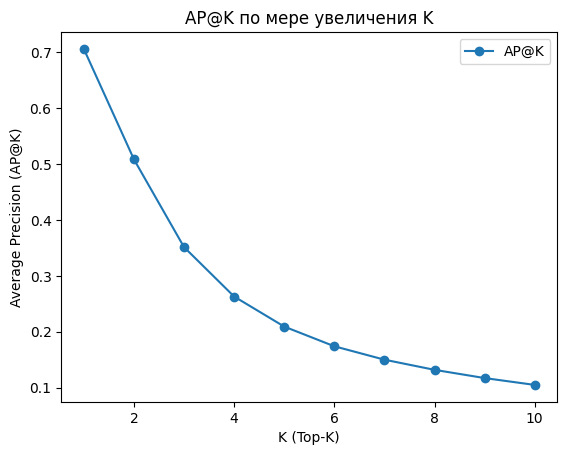

In [20]:
def compute_ap_at_k(y_true, y_scores, k_values):
    ap_at_k = []
    for k in k_values:
        top_k_indices = np.argsort(y_scores, axis=1)[:, -k:]
        top_k_predictions = np.zeros_like(y_scores)
        top_k_predictions[np.arange(len(y_true))[:, None], top_k_indices] = 1
        ap_at_k.append(average_precision_score(y_true, top_k_predictions, average='macro'))
    return ap_at_k

y_pred_prob = model.predict_proba(X_train_filtered)

k_values = range(1, 11)
ap_at_k_values = compute_ap_at_k(y_train_filtered, y_pred_prob, k_values)

plt.plot(k_values, ap_at_k_values, marker='o', label='AP@K')
plt.xlabel('K (Top-K)')
plt.ylabel('Average Precision (AP@K)')
plt.title('AP@K по мере увеличения K')
plt.legend()
plt.show()

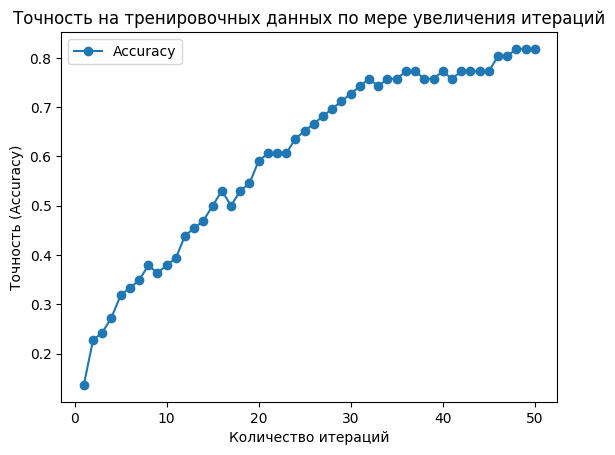

In [25]:
plt.plot(range(1, 51), accuracies, marker='o', label='Accuracy')
plt.xlabel('Количество итераций')
plt.ylabel('Точность (Accuracy)')
plt.title('Точность на тренировочных данных по мере увеличения итераций')
plt.legend()
plt.show()

In [35]:
macro_precision = precision_score(y_train_filtered, y_pred, average='macro')
print(f"Macro-Precision: {macro_precision:.4f}")

Macro-Precision: 0.8590
